In [2]:
# !rm -rf /content/sample_data
# !cp /content/drive/MyDrive/images.zip /content/
# !unzip -q /content/images.zip -d /content/images/

### CNN

In [3]:
import copy
import torch
import random
import pandas as pd
import torch.nn as nn
from pathlib import Path
import torch.nn.functional as F
from torchsummary import summary
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, roc_curve, auc

In [5]:
total = 5000

real_dir = Path.cwd() / "..images" / "real_proc"
gen_dir = Path.cwd() / "../images" / "gen_proc"

# Take images from the start of the sorted list to keep dataset balanced
# key is a function to execute to decide the order
# .stem works only with pathlib objects
real_paths = list(sorted(real_dir.glob("*.jpg"), key=lambda p: int(p.stem)))[:total]
gen_paths = list(sorted(gen_dir.glob("*.jpg"), key=lambda p: int(p.stem)))[:total]

df_real = pd.DataFrame({"path": real_paths, "label": 0})
df_gen = pd.DataFrame({"path": gen_paths, "label": 1})
df_all = pd.concat([df_real, df_gen], ignore_index=True)

pd.set_option('display.max_colwidth', None)
display(df_all.head())

,path,label
0,Path.cwd() /notebooks/../images/gen_proc/0000.jpg,1
1,Path.cwd() /notebooks/../images/gen_proc/0001.jpg,1
2,Path.cwd() /notebooks/../images/gen_proc/0002.jpg,1
3,Path.cwd() /notebooks/../images/gen_proc/0003.jpg,1
4,Path.cwd() /notebooks/../images/gen_proc/0004.jpg,1


In [6]:
df_train, df_temp = train_test_split(df_all, test_size=0.3, stratify=df_all["label"], random_state=42)
df_val, df_test = train_test_split(df_temp, test_size=0.5, stratify=df_temp["label"], random_state=42)

In [7]:
class ImageDataset(Dataset):
    """
    DataLoader calls df[i], which in pandas looks up a column, not a row. It requires a Dataset
    where __getitem__ uses positional indexing via .iloc, or data converted to tensors/ arrays
    (preloading all images, unlike a Dataset class which loads and transforms them on the fly).
    __len__ is needed to know the number of samples.
    """
    def __init__(self, df, trans=False, p_flip=0.3, p_bright=0.3):
        self.df = df.reset_index(drop=True)
        self.trans = trans
        self.p_flip = p_flip
        self.p_bright = p_bright

    def __len__(self):
        return len(self.df)

    def __getitem__(self, i):
        path = self.df.loc[i, "path"]
        label = self.df.loc[i, "label"]

        img = Image.open(path)
        img = np.array(img, dtype=np.float32) / 255.0  # shape (H, W)

        if self.trans:
            if random.random() < self.p_flip:
                img = np.flip(img, axis=1)
            if random.random() < self.p_bright:
                factor = random.uniform(0.8, 1.2)
                img = np.clip(img * factor, 0.0, 1.0)

        img = torch.from_numpy(img.copy()).unsqueeze(0)

        return img, label

In [8]:
train_ds = ImageDataset(df_train, trans=True)
val_ds = ImageDataset(df_val)
test_ds = ImageDataset(df_test)

In [9]:
class SimpleCNN(nn.Module):
    """
    1st layer: 1 input channel (greyscale image), 16 output channels (feature maps),
    3×3 kernels initialised randomly and learned during training.

    params = in_ch * out_ch * kernel h * kernel w + one bias per out_ch
    e.g.: 1 * 16 * 3 * 3 + 16 = 160
          16 * 32 * 3 * 3 + 32 = 4640

    nn.MaxPool2d(2, 2) has kernel size 2×2 and stride 2×2, reduces spacial dims by half.

    self.fc maps 64 neurons to 2 output classes
    """
    def __init__(self):
        # super() in Python calls methods of a parent class
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding="same")
        self.conv2 = nn.Conv2d(16, 32, 3, padding="same")
        self.conv3 = nn.Conv2d(32, 64, 3, padding="same")
        self.conv4 = nn.Conv2d(64, 128, 3, padding="same")

        self.bn1 = nn.BatchNorm2d(16)
        self.bn2 = nn.BatchNorm2d(32)
        self.bn3 = nn.BatchNorm2d(64)
        self.bn4 = nn.BatchNorm2d(128)

        self.mpool = nn.MaxPool2d(2, 2)
        self.apool = nn.AdaptiveAvgPool2d((4,4))
        self.dropout = nn.Dropout(0.1)
        self.fc = nn.Linear(2048, 1)

    def forward(self, x):
        x = self.mpool(F.relu(self.bn1(self.conv1(x))))
        x = self.mpool(F.relu(self.bn2(self.conv2(x))))
        x = self.mpool(F.relu(self.bn3(self.conv3(x))))
        x = self.mpool(F.relu(self.bn4(self.conv4(x))))

        x = self.apool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        return self.fc(x).squeeze(1)

In [10]:
# -1 is a placeholder for the batch size
device = "cuda" if torch.cuda.is_available() else "cpu"
model = SimpleCNN().to(device)
summary(model, input_size=(1, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 256, 256]             160
       BatchNorm2d-2         [-1, 16, 256, 256]              32
         MaxPool2d-3         [-1, 16, 128, 128]               0
            Conv2d-4         [-1, 32, 128, 128]           4,640
       BatchNorm2d-5         [-1, 32, 128, 128]              64
         MaxPool2d-6           [-1, 32, 64, 64]               0
            Conv2d-7           [-1, 64, 64, 64]          18,496
       BatchNorm2d-8           [-1, 64, 64, 64]             128
         MaxPool2d-9           [-1, 64, 32, 32]               0
           Conv2d-10          [-1, 128, 32, 32]          73,856
      BatchNorm2d-11          [-1, 128, 32, 32]             256
        MaxPool2d-12          [-1, 128, 16, 16]               0
AdaptiveAvgPool2d-13            [-1, 128, 4, 4]               0
          Dropout-14                 [-

In [11]:
def train_model(train_ds, val_ds, batch_size, lr_init, wd, n_epochs, patience):

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

    model = SimpleCNN().to(device)
    optim = torch.optim.Adam(model.parameters(), lr=lr_init, weight_decay=wd)
    crit = nn.BCEWithLogitsLoss()
    scheduler = ReduceLROnPlateau(optim, mode='min', factor=0.5, patience=2)

    # Set up lists to track losses
    best_val_loss = float('inf')
    epochs_no_improve = 0
    train_losses = []
    val_losses = []

    for epoch in range(n_epochs):
        # Set model to training mode
        model.train()
        train_loss = 0.0

        for bat_x, bat_y in train_loader:
            bat_x, bat_y = bat_x.to(device), bat_y.to(device)

            # Forward pass
            outputs = model(bat_x) # Randomly initialised by PyTorch by default the first time it runs
            loss = crit(outputs, bat_y.float())

            # Backward pass
            optim.zero_grad()   # Clear previous gradients
            loss.backward()     # Compute gradients
            optim.step()        # Update parameters

            train_loss += loss.item()

        # Record average training loss for this epoch
        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        # Set model to evaluation mode and evaluate on the validation set
        model.eval()
        val_loss = 0.0

        with torch.no_grad():
            for bat_x, bat_y in val_loader:
                bat_x, bat_y = bat_x.to(device), bat_y.to(device)

                outputs = model(bat_x)
                loss = crit(outputs, bat_y.float())

                val_loss += loss.item()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        scheduler.step(val_loss)

        print(f"Epoch {epoch + 1:>2}/{n_epochs}, train loss: {train_loss:.4f}, val loss: {val_loss:.4f}, lr: {optim.param_groups[0]['lr']}")

        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
            best_model_wts = copy.deepcopy(model.state_dict())
        else:
            epochs_no_improve += 1
            if epochs_no_improve == patience:
                print(f"Early stopping triggered after epoch {epoch + 1}")
                break

    model.load_state_dict(best_model_wts)
    return model, train_losses, val_losses

In [57]:
model, train_losses, val_losses = train_model(train_ds, val_ds, batch_size=64, lr_init=1e-4, wd=1e-5, n_epochs=100, patience=6)

Epoch  1/100, train loss: 0.4686, val loss: 0.3833, lr: 0.0001
Epoch  2/100, train loss: 0.3744, val loss: 0.3095, lr: 0.0001
Epoch  3/100, train loss: 0.3452, val loss: 0.3878, lr: 0.0001
Epoch  4/100, train loss: 0.3312, val loss: 0.2886, lr: 0.0001
Epoch  5/100, train loss: 0.3258, val loss: 0.2817, lr: 0.0001
Epoch  6/100, train loss: 0.3166, val loss: 0.2960, lr: 0.0001
Epoch  7/100, train loss: 0.3107, val loss: 0.3036, lr: 0.0001
Epoch  8/100, train loss: 0.2999, val loss: 0.2752, lr: 0.0001
Epoch  9/100, train loss: 0.2992, val loss: 0.3367, lr: 0.0001
Epoch 10/100, train loss: 0.2914, val loss: 0.3047, lr: 0.0001
Epoch 11/100, train loss: 0.2845, val loss: 0.2491, lr: 0.0001
Epoch 12/100, train loss: 0.2810, val loss: 0.2513, lr: 0.0001
Epoch 13/100, train loss: 0.2806, val loss: 0.2380, lr: 0.0001
Epoch 14/100, train loss: 0.2758, val loss: 0.2421, lr: 0.0001
Epoch 15/100, train loss: 0.2672, val loss: 0.2472, lr: 0.0001
Epoch 16/100, train loss: 0.2582, val loss: 0.2508, lr:

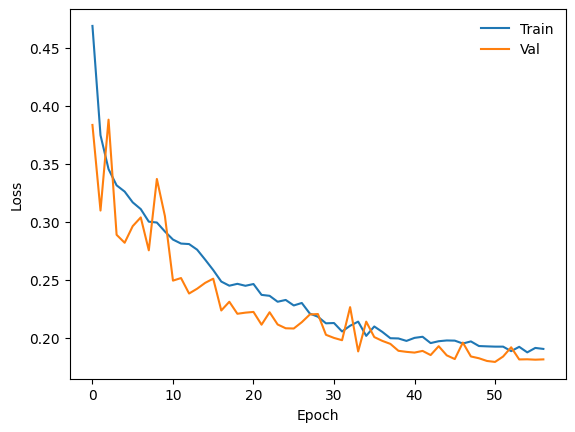

In [58]:
plt.plot(train_losses, label="Train")
plt.plot(val_losses, label="Val")
plt.legend(frameon=False)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [59]:
test_loader = DataLoader(test_ds, batch_size=128, shuffle=False)

y_true, y_pred, probs = [], [], []
model.eval()
th = 0.5

with torch.no_grad():
    for bat_x, bat_y in test_loader:
        bat_x, bat_y = bat_x.to(device), bat_y.to(device)

        logits = model(bat_x)
        prob = torch.sigmoid(logits)

        y_true.append(bat_y.cpu().numpy())
        y_pred.append((prob > th).int().cpu().numpy())
        probs.append(prob.cpu().numpy())

y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)
probs = np.concatenate(probs)

In [60]:
cm = confusion_matrix(y_true, y_pred)
acc = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"Confusion matrix:\n{cm}")
print(f"Accuracy: {acc:.3f}")
print(f"F1 Score: {f1:.3f}")

Confusion matrix:
[[676  68]
 [ 28 722]]
Accuracy: 0.936
F1 Score: 0.938


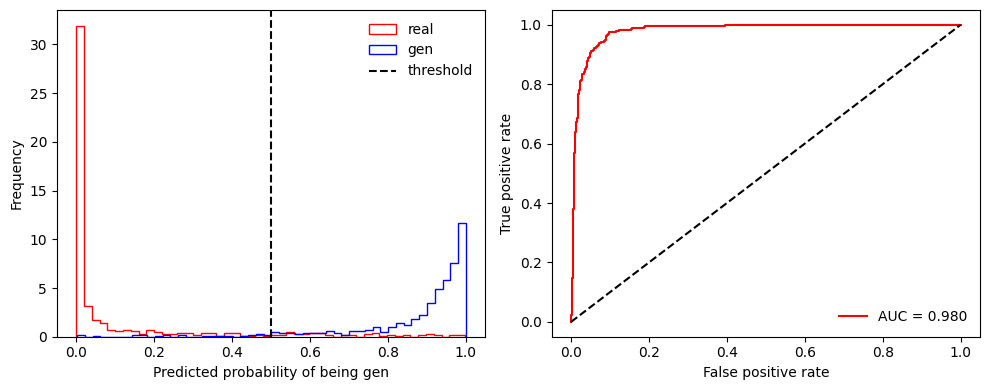

In [65]:
fpr, tpr, _ = roc_curve(y_true, probs)
roc_auc = auc(fpr, tpr)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

ax1.hist(probs[y_true == 0], bins=50, density=True, histtype='step', color='r', label='real')
ax1.hist(probs[y_true == 1], bins=50, density=True, histtype='step', color='b', label='gen')
ax1.axvline(x=th, linestyle='--', color='k', label='threshold')
ax1.set_xlabel("Predicted probability of being gen")
ax1.set_ylabel("Frequency")
ax1.legend(frameon=False, loc='upper right')

ax2.plot(fpr, tpr, color='r', label=f"AUC = {roc_auc:.3f}")
ax2.plot([0, 1], [0, 1], color='k', linestyle='--')
ax2.set_xlabel("False positive rate")
ax2.set_ylabel("True positive rate")
ax2.legend(frameon=False)

plt.tight_layout()
plt.show()

In [ ]:
model.to('cpu').eval()
example_input = torch.randn(1, 1, 256, 256)  # example input shape
traced_model = torch.jit.trace(model, example_input)
torch.jit.save(traced_model, "model.pt")